Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [2]:
# Подключаем необходимые библиотеки
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Считываем данные
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

Проведем разведочный анализ данных

In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
groups.shape

(74484, 2)

In [8]:
groups.id.nunique()

74484

In [9]:
groups.groupby('grp', as_index=False).agg({'id': 'count'})

,grp,id
0,A,14671
1,B,59813


In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_studs.shape

(8341, 1)

In [12]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [13]:
active_studs.nunique()

student_id    8341
dtype: int64

In [14]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
checks.shape

(541, 2)

In [16]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [17]:
checks.student_id.nunique()

541

In [3]:
# Соединяем информацию активных пользователей в дни проведения эксперимента и их оплаты
checks_active_studs = active_studs.merge(checks, how='left', on='student_id')
checks_active_studs.head()

,student_id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


In [4]:
# NAN означают что данные юзеры не совершали оплат в дни эксперимента, заменим их нулями и поменяем названия колонок
checks_active_studs = checks_active_studs.fillna(0).rename(columns={'student_id': 'id'})

In [5]:
# Соединим нашу таблицу с таблицей groups
df = checks_active_studs.merge(groups, how='inner', on='id')
df.head()

,id,rev,grp
0,581585,0.0,A
1,3276743,0.0,B
2,4238589,0.0,A
3,4475369,0.0,B
4,5481015,0.0,B


Т.к. изменения связаны с новой механикой оплаты на сайте в первую очередь интересно посмотреть изменения в конверсии.
Возможно оплата на сайте стала более прозрачна и конверсия увеличилась

In [6]:
# Для этого нам интересно посмотреть сам факт совершения покупки (1 купили и 0 не купили)
df['purchase'] = (df.rev > 0) * 1
df.head()

,id,rev,grp,purchase
0,581585,0.0,A,0
1,3276743,0.0,B,0
2,4238589,0.0,A,0
3,4475369,0.0,B,0
4,5481015,0.0,B,0


In [22]:
# Посмотрим CR по группам
df.groupby('grp', as_index=False).agg({'purchase': 'mean'}).rename(columns=({'purchase': 'CR'}))

,grp,CR
0,A,0.050814
1,B,0.046077


In [7]:
# На первый взгляд CR ухудшилась, но для того чтобы убедиться в этом воспользуемся Хи-квадрат тестом
df_pivot = df.groupby(['grp', 'purchase'], as_index=False).agg({'id': 'count'})\
                                                         .pivot(index='purchase', columns='grp', values='id')
df_pivot

grp,A,B
purchase,,
0,1457,6480
1,78,313


In [24]:
p = chi2_contingency(df_pivot)[1]
p

0.46803677583199144

Так как р>0.05 то различия в CR между группами статистически не значимы

Если в обеих группах конверсия 'одинакова', важно проверить различия  в средних чеках с купивших юзеров(ARPPU)

In [25]:
df.query('rev>0').groupby('grp', as_index=False).agg({'rev': 'mean'}).rename(columns=({'rev': 'mean_rev'}))

,grp,mean_rev
0,A,933.589744
1,B,1255.827487


Т.к. ARPPU различаются, необходимо проверить эту гипотезу
Для этого посмотрим распределения revenue по группам

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


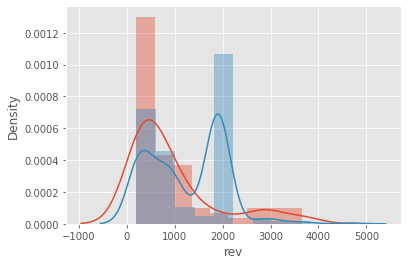

In [26]:
sns.distplot(df.query('rev>0 & grp=="A"').rev)
sns.distplot(df.query('rev>0 & grp=="B"').rev)

In [7]:
# Т.к. распрежедения не нормальные, лучше всего применить bootstrap
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(12, 8))
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

In [8]:
get_bootstrap(
    df.query('rev>0 & grp=="A"').rev,  # числовые значения первой выборки
    df.query('rev>0 & grp=="B"').rev,  # числовые значения второй выборки
    boot_it= 1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level= 0.95  # уровень значимости
)

NameError: name 'df' is not defined

Т.к р<0.05 то различия ARPPU между группами статистически значимы

Исходя из результатов проверки эксперимента можно сказать следующее:
У целевой группы увеличился ARPPU и нет статистически значимого ухудшения в конверсии с контрольной группой - можно запускать новую механику оплаты
Можно предположить, что новая механика связана с продвижением доп.товаров при оплате(механика должна увеличить выручку но и не отпугнуть клиента)

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Предположим что дополнительный файл должен иметь ту же размерность и типы данных, что и основной файл

In [9]:
def add_file(x):
    add_file = pd.read_csv(x)  # считываем дополнительный файл
    if add_file.dtypes[0] == 'int64' and add_file.dtypes[1] == 'object':
        add_file.rename(columns=({add_file.columns[0]: 'id', add_file.columns[1]: 'grp'}), inplace=True)
    else:
        add_file.rename(columns=({add_file.columns[0]: 'grp', add_file.columns[1]: 'id'}), inplace=True)
    # в зависимости от типа колонок, переименовываем колонки
    active_studs = pd.read_csv('Проект_2_active_studs.csv')
    checks = pd.read_csv('Проект_2_checks.csv', sep=';')
    # считывание основных файлов
    checks_active_studs = active_studs.merge(checks, how='left', on='student_id')
    checks_active_studs = checks_active_studs.fillna(0).rename(columns={'student_id': 'id'})
    full = pd.concat([groups, add_file])
    df = checks_active_studs.merge(full, how='inner', on='id')
    df['purchase'] = (df.rev > 0) * 1
    CR = df.groupby('grp', as_index=False).agg({'purchase': 'mean'}).rename(columns=({'purchase': 'CR'}))
    AVG = df.query('rev>0').groupby('grp', as_index=False).agg({'rev': 'mean'}).rename(columns=({'rev': 'ARPPU'}))
    # пересчет метрик
    return ({'CR': CR, 'AVG': AVG, 'columns': add_file.columns})

In [11]:
recalculate = add_file('Проект_2_group_add.csv')
recalculate

{'CR':   grp        CR
 0   A  0.050715
 1   B  0.046156,
 'AVG':   grp        ARPPU
 0   A   933.589744
 1   B  1257.878992,
 'columns': Index(['id', 'grp'], dtype='object')}

In [6]:
def barplot(recalculate):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    sns.barplot(ax=axes[0], x='grp', y='ARPPU', data=recalculate['AVG'])
    sns.barplot(ax=axes[1], x='grp', y='CR', data=recalculate['CR'])

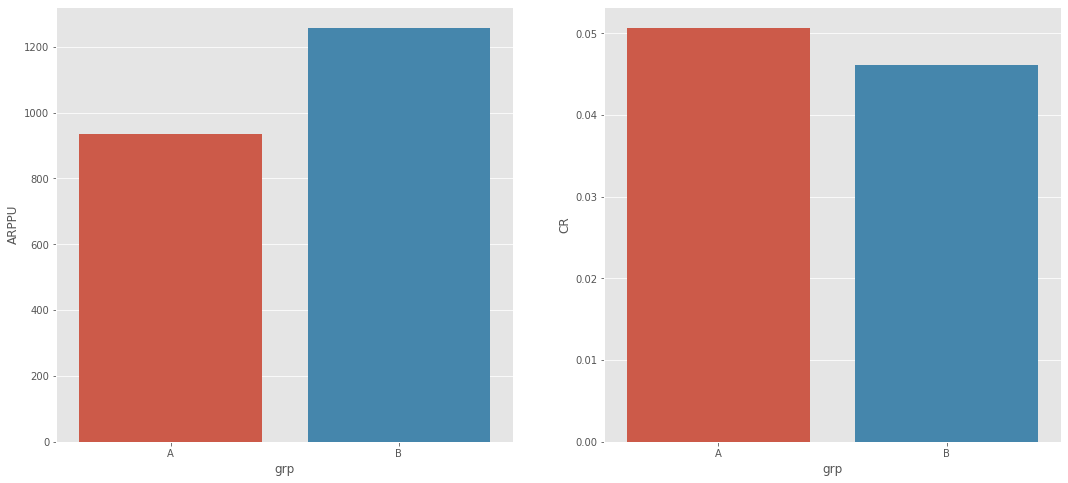

In [38]:
barplot(recalculate)